In [1]:
import matplotlib.pyplot as plt
import mibitrans as mbt
import numpy as np

### Field site example: Keesler Air-Force Base

The distribution of BIOSCREEN v1.4 is accompanied by an field site example of the Keesler Air Force Base in Mississippi, USA. As the data is sourced from the USA, units are mixed imperial and metric. For the modelling below, all parameters are converted to metric for consistency [1].

#### Site description
In 1987, during their removal, multiple underground storage tanks (UST) leaked a mixture of BTEX and lead to the groundwater. Remediation efforts included a 'bioventing' system and an in well aeration system. Monitoring wells were used to evaluate natural attenuation [2,3]. Local geology is a fine- to medium-grained sand, underlain by a clay layer at 20ft depth. Bottom of sandy layer has local presence of peat. Thickness and continuity of clay layer are unknown, but not every boring showed the clay layer at 20ft. Assumption of clay continuous clay layer was made. Unconfined aquifer with groundwater levels varying between 5 and 9 ft below ground level. Groundwater flow is to the north-east, which eventually discharges into the Back Bay of Biloxi, 2100ft downgradient [4]. Values of hydraulic gradient and conductivity vary, with values of 0.003 to 0.0083 ft/ft and 40, 61, 32 ft/day listed in [4]. In [1]. the values of 0.003 ft/ft and 0.011 cm/sec (31.2 ft/day) were used. Effective porosity is estimated to be 0.25 [4], resulting in groundwater velocity of 0.8 ft/day. Although [1] uses an effective porosity of 0.3, and results in groundwater velocity of 0.31 ft/day. For consistency, values reported in [1] are used in the modelling. Dispersivity values were based on estimated plume length of 280ft [1]. With 13.3ft, 1.3ft and 0ft for longitudinal, transverse horizontal and transverse vertical dispersivity respectively. After calibration, these values were changed to 32.5ft, 3.25ft and 0ft respectively [1].

In [2]:
ft = 3.281 #Conversion factor ft/m

hydro_pars = mbt.HydrologicalParameters(
    h_conductivity = 0.011 / 100 * 3600 * 24, #m/d
    h_gradient = 0.003, # m/m
    porosity = 0.3,
    alpha_x = 32.5 / ft, #m
    alpha_y = 3.25 / ft, #m
    alpha_z = 0
)
print(hydro_pars.velocity)

0.09504


The fraction of organic carbon is 0.000057 based of lab analysis, soil bulk density is estimated to be 1.7 (kg/L) [1]. Partition coefficient of BTEX differs by order of magnitude (38, 135, 95, 240 L/kg for B, T, E, X), [1] uses the value of benzene; 38 L/kg. Electron acceptor concentrations are based on groundwater sampling performed in 1995. For oxygen, nitrate and sulfate, the difference between background concentration in the aquifer and minimum concentrations in the plume are used. For ferrous iron and methane, average concentrations in the plume area are used. Values differ somewhat from those reported in [4] (elaborate?).

In [3]:
att_pars = mbt.AttenuationParameters(
    bulk_density=1.7, # kg/L (note; for consistency, should use g/m3, but since units cancel out here for calculation, using more intuitive kg/L instead)
    partition_coefficient=38, # L/kg (units cancel out with bulk density)
    fraction_organic_carbon=0.000057,
    decay_rate = 0, # 1/day, for now, we do not consider linear decay rate.
)
att_pars.calculate_retardation(hydro_pars.porosity)
print("Retardation based on input values =", att_pars.retardation)

electron_acceptor_concentrations = mbt.ElectronAcceptors(
    delta_oxygen=2.05 - 0.4, #background conc - minimum conc, [g/m3]
    delta_nitrate=0.07 - 0, #background conc - minimum conc, [g/m3]
    ferrous_iron=16.6, #average conc, [g/m3]
    delta_sulfate=26.2 - 3.8, #background conc - minimum conc, [g/m3]
    methane=6.6, #average conc, [g/m3]
)

Retardation based on input values = 1.012274


Conditions and parameters of the contaminant source were inferred from BTEX monitoring data and geologic logs [1]. The source thickness is estimated to be 10ft, with a total 2000kg of pure BTEX. Total source width of 130ft, with 28ft zone of 0.057 g/m3, 30ft zone of 2.508 g/m3, 14ft zone of 13.68, 30ft zone of 2.508 g/m3, 28ft zone of 0.057 g/m3.

In [4]:
source_pars = mbt.SourceParameters(
    # Note; as plume is symmetric, source is described from center outwards in y-direction.
    source_zone_boundary=np.array([7/ft, 37/ft, 65/ft]), #[m]
    source_zone_concentration=np.array([13.68, 2.508, 0.057]), #[g/m3]
    depth=10/ft, #[m]
    total_mass=2000000, #[g]
)

Model dimensions used for the BIOSCREEN model are; length = 320ft, width = 200ft, duration=6y [1]. In BIOSCREEN resolution is always a fraction of model dimensions, 1/10 for length, 1/4 for width and 1/10 for time. For the mibitrans package, model resolution is freely changeable

In [28]:
model_pars = mbt.ModelParameters(model_length=1000/ft,
                                 model_width=200/ft,
                                 model_time=10*365,
                                 dx=5/ft,
                                 dy=1/ft,
                                 dt=365/5)

#### Models

With the model parameters entered, the model is run with the three models implemented in mibitrans. The Bioscreen model class performs the same calculations as those implemented in BIOSCREEN. The Anatrans model class uses the untruncated form of the Bioscreen model, the additional term increases accuracy for small times and distances. The Mibitrans model class uses an analytical solution based on Wexler (1992). For further details about each analytical model, see the 'example_walkthrough' notebook and the theory that accompany this package.

In [29]:
bio_model = mbt.Bioscreen(hydrological_parameters=hydro_pars,
                          attenuation_parameters=att_pars,
                          source_parameters=source_pars,
                          model_parameters=model_pars,)
bio_results = bio_model.run()
bio_results.centerline()
plt.show()


In [30]:
ana_model = mbt.Anatrans(hydrological_parameters=hydro_pars,
                          attenuation_parameters=att_pars,
                          source_parameters=source_pars,
                          model_parameters=model_pars,)
ana_results = ana_model.run()
ana_results.centerline()
plt.show()

In [31]:
mbt_model = mbt.Mibitrans(hydrological_parameters=hydro_pars,
                          attenuation_parameters=att_pars,
                          source_parameters=source_pars,
                          model_parameters=model_pars)
mbt_results =mbt_model.run()
mbt_results.centerline()
plt.show()

Comparing the three models at the first time step shows that the Bioscreen model underestimates the source concentrations. The Anatrans and Mibitrans models start at the correct source zone concentration, but show different behaviour along the domain.

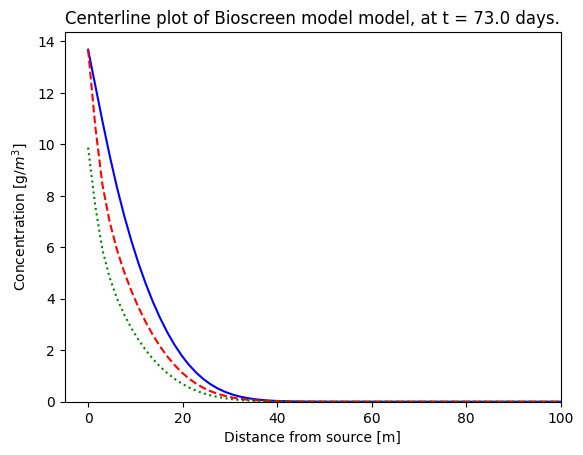

In [25]:
time_point = 365/5
mbt_results.centerline(time=time_point, label="mbt", color="blue")
ana_results.centerline(time=time_point, label="ana", color="red", linestyle="--")
bio_results.centerline(time=time_point, label="bio", color="green", linestyle=":")
plt.xlim((-5,100)) # Reduce the x-axis limit to better observe differences
plt.show()

In [26]:
# Needed to show animations in Jupyter Notebook
%matplotlib notebook

Over time, the source concentration for the Bioscreen model increases to the correct value, and the results resolve to that of the Anatrans model. Differences between the Anatrans and Mibitrans model decrease

In [32]:
anim = mbt.centerline([mbt_results, ana_results, bio_results], legend_names=["mbt", "ana", "bio"], animate=True)
plt.show()

<IPython.core.display.Javascript object>

In [57]:
bio_model.instant_reaction(electron_acceptors=electron_acceptor_concentrations)
ana_model.instant_reaction(electron_acceptors=electron_acceptor_concentrations)
mbt_model.instant_reaction(electron_acceptors=electron_acceptor_concentrations)
bio_results_instant = bio_model.run()
ana_results_instant = ana_model.run()
mbt_results_instant = mbt_model.run()

In [58]:
anim = mbt.centerline([mbt_results_instant, ana_results_instant, bio_results_instant], legend_names=["mbt", "ana", "bio"], animate=True)
plt.show()

<IPython.core.display.Javascript object>

In [59]:
time_point = 365 * 5
plt.figure()
mbt_results_instant.centerline(time=time_point, label="mbt", color="blue")
ana_results_instant.centerline(time=time_point, label="ana", color="red", linestyle="--")
bio_results_instant.centerline(time=time_point, label="bio", color="green", linestyle=":")


field_data_x = np.array([0, 32/ft, 64/ft, 192/ft, 288/ft])
field_data_c = np.array([12,5,1,0.5,0.001])
plt.scatter(field_data_x, field_data_c, color="black")
plt.xlim(0,150)
plt.show()

<IPython.core.display.Javascript object>

According to Bioscreen, the above model predicts the measured field concentrations fairly well

In [60]:
plt.figure()
plt.plot(mbt_results_instant.x, mbt_results_instant.cxyt_noBC[-1,100,:])
plt.plot(ana_results_instant.x, ana_results_instant.cxyt_noBC[-1, 100, :])
plt.plot(bio_results_instant.x, bio_results_instant.cxyt_noBC[-1, 100, :])
plt.show()

<IPython.core.display.Javascript object>

(1) Newell, C. J., McLeod, R. K., & Gonzales, J. R. (1997). BIOSCREEN natural attenuation decision support
    system version 1.4 revisions, Tech. rep., U.S. EPA.

(2)https://webapp1.dlib.indiana.edu/virtual_disk_library/index.cgi/4908754/FID2958/abstracts/00000166.html (make actual citation, maybe not include, since is summary of (3)

(3) COST AND PERFORMANCE CASE STUDY REPORT - Keesler Air Force Base Base Exchange Service Station (make actual citation)

(4) Corrective action plan for the risk-based closure of the base exchange service station, area of concern - A (ST-06) Keesler Air Froce Base, Mississippi (make actual citation)


https://www.sunherald.com/news/local/military/article234197522.html